<a href="https://colab.research.google.com/github/beknur/machine-learning/blob/master/kickstarter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

from datetime import datetime
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [216]:
projects = pd.read_csv('ks-projects-201801.csv')
print("all=>",len(projects))
projects = projects[(projects['state'] == 'failed') | (projects['state'] == 'successful')]
print("success & failed projects=>", len(projects))
projectsFailed = projects[(projects['state'] == 'failed')]
projectsSuccess = projects[(projects['state'] == 'successful')]

all=> 378661
success & failed projects=> 331675


In [80]:
print("Count failed projects: ", len(projectsFailed) , ", Count success projects: ", len(projectsSuccess))
projects.head()

Count failed projects:  197719 , Count success projects:  133956


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,successful,224,US,52375.0,52375.0,50000.00


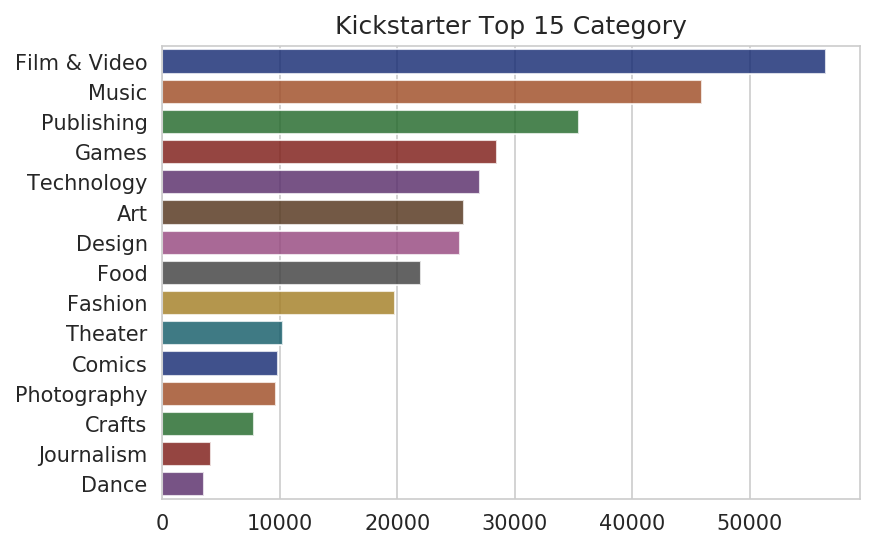

In [217]:
sns.set_style('whitegrid')
mains = projects.main_category.value_counts().head(15)
x = mains.values
y = mains.index

fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax = sns.barplot(y=y, x=x, orient='h', palette="dark", alpha=0.8)
plt.title('Kickstarter Top 15 Category')
plt.show()

In [182]:
total_projects = projects[['ID', 'main_category']].groupby(['main_category']).count().sort_values('ID', ascending=False)
grouped = projects[['name', 'main_category', 'state']].groupby(['main_category', 'state']).count()
total = total_projects[['ID']].rename(columns={'ID': 'total'})
final_df = grouped.join(total, on='main_category').sort_values('total', ascending=False)
final_df.head(15)

name  total
main_category state                   
Film & Video  failed      32903  56527
              successful  23623  56527
Music         successful  24197  45949
              failed      21752  45949
Publishing    successful  12300  35445
              failed      23145  35445
Games         successful  12518  28521
              failed      16002  28521
Technology    successful   6434  27050
              failed      20616  27050
Art           failed      14130  25641
              successful  11510  25641
Design        failed      14814  25364
              successful  10550  25364
Food          successful   6085  22054

In [214]:
total_projects = projects[['ID', 'main_category']].groupby(['main_category']).count().sort_values('ID', ascending=False)
grouped = projects[['name', 'main_category', 'state']].groupby(['main_category', 'state']).count()
total = total_projects[['ID']].rename(columns={'ID': 'total'})
final_df1 = grouped.join(total, on='main_category').sort_values('total', ascending=False)


<bound method _flex_comp_method_FRAME.<locals>.f of                            name  total
main_category state                   
Film & Video  failed      32903  56527
              successful  23623  56527
Music         successful  24197  45949
              failed      21752  45949
Publishing    successful  12300  35445
              failed      23145  35445
Games         successful  12518  28521
              failed      16002  28521
Technology    successful   6434  27050
              failed      20616  27050
Art           failed      14130  25641
              successful  11510  25641
Design        failed      14814  25364
              successful  10550  25364
Food          successful   6085  22054
              failed      15969  22054
Fashion       successful   5593  19775
              failed      14182  19775
Theater       failed       3708  10242
              successful   6534  10242
Comics        successful   5842   9878
              failed       4036   9878
Photography 

In [0]:
projects['length_days'] = (pd.to_datetime(projects['deadline']) - pd.to_datetime(projects['launched'])).dt.days + 1

In [13]:
print('Mean days for failed projects: {0}'
      .format(round(projects[projects['state'] == 'failed']['length_days'].mean(), 2)))
print('Mean days for successful projects: {0}'
      .format(round(projects[projects['state'] == 'successful']['length_days'].mean(), 2)))

Mean days for failed projects: 35.32
Mean days for successful projects: 31.92


In [0]:
# Selecting features
projects_data = projects[['state', 'main_category', 'country', 'usd_goal_real']]

# Modifing value of dependent variable from categorical to numerical
projects_data.loc[projects_data['state'] == 'failed', 'state'] = 0
projects_data.loc[projects_data['state'] == 'successful', 'state'] = 1

# Scaling goal amount since it behaves differently in each category
for cat in projects_data['main_category'].unique():
    scaler = StandardScaler()
    new_values = scaler.fit_transform(projects_data[projects_data['main_category'] == cat][['usd_goal_real']])
    projects_data.loc[projects['main_category'] == cat, 'usd_goal_real'] = new_values.transpose()[0]

# Modifing independent variables to dummies
projects_data = pd.get_dummies(projects_data)

In [16]:
# Spliting data
train_X, test_X, train_y, test_y = train_test_split(projects_data.drop('state', axis=1), projects_data['state'], 
                                                    test_size=0.1, random_state=7)

# Creating model
LR = LogisticRegression()

# Fitting model
LR.fit(train_X, train_y)

# Scoring
print("Model's accuracy is {0}%".format(round(LR.score(test_X, test_y)*100, 2)))

Model's accuracy is 65.39%


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



In [17]:
from_largest = np.argsort(LR.coef_)[0][::-1]
positive_coef_inds = []
for index in from_largest:
    if LR.coef_[0][index] > 0:
        positive_coef_inds.append(index)
    else:
        break
print(train_X.iloc[:, positive_coef_inds].columns)

Index(['main_category_Theater', 'country_HK', 'main_category_Dance',
       'main_category_Comics', 'country_N,0"', 'main_category_Music',
       'country_SG', 'country_US', 'country_GB', 'country_BE', 'country_CH',
       'main_category_Art', 'country_IE', 'country_CA', 'main_category_Games',
       'main_category_Film & Video', 'main_category_Design'],
      dtype='object')


In [18]:
print(train_X.iloc[:, np.argmin(LR.coef_[0])].name)

usd_goal_real
